Installing necessary libraries

In [1]:
!pip install --upgrade --ignore-installed kaggle

     |████████████████████████████████| 61kB 4.9MB/s 
     |████████████████████████████████| 153kB 13.2MB/s 
     |████████████████████████████████| 235kB 56.0MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
     |████████████████████████████████| 143kB 45.5MB/s 
     |████████████████████████████████| 184kB 48.7MB/s 
     |████████████████████████████████| 61kB 10.8MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=86db4c5cded66a5e2511493d10d34e86323404bc2950fe39a6a78f30e7f69d3f
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
  Created wheel for python-slugify: filename=python_slugify-4.0.1-py2.py3-none-any.whl size=6769 sha256=7f47b19ff3d1ea9de1e67fb2a778755cba5e4e6c632a454c86f33d2a3b263f3b
  Stored in directory: /root/.cache/pip/wheels/67/b8/ba/041548f30a6fc058c9b

Uploading dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ameeraarif","key":"5a2c5d37596e760db6ffa8449f89a47a"}'}

In [3]:
!mkdir ~/.kaggle #created at root folder in colab
#copy
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:02<00:00, 171MB/s]
100% 346M/346M [00:02<00:00, 150MB/s]


In [4]:
#unzip dataset in colab session
!unzip -q intel-image-classification.zip # -q for quiet

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# copy zipped dataset into your drive
!cp "/content/intel-image-classification.zip" /content/drive/MyDrive/

In [19]:
!unzip Testtplzwork.zip -d new_pred_dataplz

Streaming output truncated to the last 5000 lines.
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/16635.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/15648.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/8704.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/13694.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/2206.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/4649.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/22297.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/9732.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/16177.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/5807.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/17271.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/12443.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/6211.jpg  
  inflating: new_pred_dataplz/seg_pred/seg_pred/street/2696.jpg  
  inflating: new_p

Image augmentation and data loading

In [7]:
# necessary imports
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
from matplotlib import pyplot
import keras
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential

import matplotlib.pyplot as plt


In [8]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (32,32))  # incase images not of same size
      
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

In [9]:
train_dir = "/content/seg_train/seg_train/"
test_dir = "/content/seg_test/seg_test/"

print('loading train images')
X_train, y_train = load_data(train_dir)
print('loading validation images')
X_test, y_test = load_data(test_dir)


  7%|▋         | 145/2191 [00:00<00:01, 1445.39it/s]

loading train images


 48%|████▊     | 210/437 [00:00<00:00, 2097.12it/s]

loading validation images


100%|██████████| 501/501 [00:00<00:00, 2062.59it/s]


In [20]:
pred_dir = "/content/new_pred_dataplz/seg_pred/seg_pred/"
print('loading pred images')
X_pred, y_pred = load_data(pred_dir)


 18%|█▊        | 208/1144 [00:00<00:00, 2077.33it/s]

loading pred images


100%|██████████| 1236/1236 [00:00<00:00, 2047.96it/s]


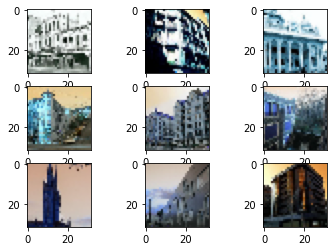

In [10]:
# Actual dataset
for i in range(0,9):
  pyplot.subplot(330+1+i)
  pyplot.imshow(X_train[i], cmap = pyplot.get_cmap('gray'))
pyplot.show()

Image augmentation

In [11]:
# Image augmentation
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

datagen = ImageDataGenerator(
                             rotation_range=15, #best
                             shear_range=0.15, #best
                             horizontal_flip=True, #best
                             height_shift_range=0.5 #best
                             )

# fit parameters from data
datagen.fit(X_train)


Making my own VGG model from scratch

In [12]:
model = Sequential()

In [13]:
model.add(Conv2D(input_shape=(32,32,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
 
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
 
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
 
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
 
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=6, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="self_made_model_image_aug.png", show_shapes=True)

Loading data

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(X_pred.shape)
print(y_train.shape)
print(y_test.shape)
print(y_pred.shape)

(14034, 32, 32, 3)
(3000, 32, 32, 3)
(7301, 32, 32, 3)
(14034,)
(3000,)
(7301,)


In [15]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)


In [22]:
y_pred= lb.fit_transform(y_pred)

Training with different hyperparameters

In [ ]:
#TRYING DIFFERENT PARAMETERS (lr=0.01 SGD momentum 0.8)
from keras.optimizers import SGD
import datetime
now = datetime.datetime.now
t = now()
sgd = SGD(lr=0.01, decay=1e-7, momentum=.8)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])
H1 = model.fit(X_train, y_train, batch_size=64,
              epochs=30, 
              validation_data=(X_test, y_test))
print('Training time: %s' % (now() - t))
best_scoreH1 = max(H1.history['accuracy'])
print(best_scoreH1)

Epoch 1/30
220/220 [==============================] - 10s 41ms/step - loss: 1.7930 - accuracy: 0.1676 - val_loss: 1.7898 - val_accuracy: 0.1750
Epoch 2/30
220/220 [==============================] - 9s 40ms/step - loss: 1.7910 - accuracy: 0.1788 - val_loss: 1.7902 - val_accuracy: 0.1750
Epoch 3/30
220/220 [==============================] - 9s 41ms/step - loss: 1.7910 - accuracy: 0.1801 - val_loss: 1.7904 - val_accuracy: 0.1750
Epoch 4/30
220/220 [==============================] - 9s 41ms/step - loss: 1.7907 - accuracy: 0.1789 - val_loss: 1.7900 - val_accuracy: 0.1750
Epoch 5/30
220/220 [==============================] - 9s 41ms/step - loss: 1.7907 - accuracy: 0.1824 - val_loss: 1.7900 - val_accuracy: 0.1750
Epoch 6/30
220/220 [==============================] - 9s 41ms/step - loss: 1.7908 - accuracy: 0.1811 - val_loss: 1.7901 - val_accuracy: 0.1750
Epoch 7/30
220/220 [==============================] - 9s 41ms/step - loss: 1.7902 - accuracy: 0.1859 - val_loss: 1.7903 - val_accuracy: 0.175

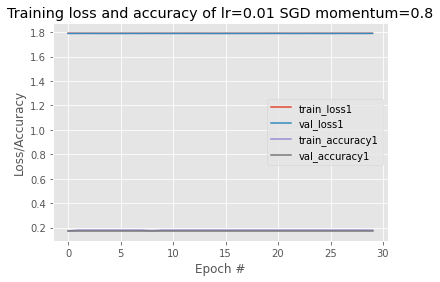

In [ ]:

N = np.arange(0, 30)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H1.history['loss'], label='train_loss1')
plt.plot(N, H1.history['val_loss'], label='val_loss1')
plt.plot(N, H1.history['accuracy'], label='train_accuracy1')
plt.plot(N, H1.history['val_accuracy'], label='val_accuracy1')


plt.title('Training loss and accuracy of lr=0.01 SGD momentum=0.8')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
#TRYING DIFFERENT PARAMETERS (lr=0.001 adam batch_size=128)

from keras.optimizers import Adam
import datetime
now = datetime.datetime.now
t = now()
adam = Adam(lr=0.001, decay=1e-7)
model.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])
H3 = model.fit(X_train, y_train, batch_size=128,
              epochs=30, 
              validation_data=(X_test, y_test))
print('Training time: %s' % (now() - t))
best_scoreH3 = max(H3.history['accuracy'])
print(best_scoreH3)

Epoch 1/30
110/110 [==============================] - 8s 65ms/step - loss: 1.8444 - accuracy: 0.4779 - val_loss: 0.7847 - val_accuracy: 0.7253
Epoch 2/30
110/110 [==============================] - 7s 64ms/step - loss: 0.6341 - accuracy: 0.7866 - val_loss: 0.6662 - val_accuracy: 0.7790
Epoch 3/30
110/110 [==============================] - 7s 64ms/step - loss: 0.4476 - accuracy: 0.8543 - val_loss: 0.6203 - val_accuracy: 0.7927
Epoch 4/30
110/110 [==============================] - 7s 64ms/step - loss: 0.3705 - accuracy: 0.8846 - val_loss: 0.6015 - val_accuracy: 0.8093
Epoch 5/30
110/110 [==============================] - 7s 63ms/step - loss: 0.2918 - accuracy: 0.9070 - val_loss: 0.6281 - val_accuracy: 0.8023
Epoch 6/30
110/110 [==============================] - 7s 64ms/step - loss: 0.2631 - accuracy: 0.9155 - val_loss: 0.6749 - val_accuracy: 0.8037
Epoch 7/30
110/110 [==============================] - 7s 63ms/step - loss: 0.2173 - accuracy: 0.9331 - val_loss: 0.7617 - val_accuracy: 0.7950

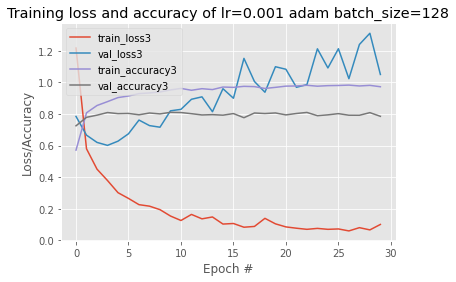

In [ ]:

N = np.arange(0, 30)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H3.history['loss'], label='train_loss3')
plt.plot(N, H3.history['val_loss'], label='val_loss3')
plt.plot(N, H3.history['accuracy'], label='train_accuracy3')
plt.plot(N, H3.history['val_accuracy'], label='val_accuracy3')


plt.title('Training loss and accuracy of lr=0.001 adam batch_size=128')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.optimizers import SGD
import datetime
now = datetime.datetime.now
t = now()
epochs = 30
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# Fit the model
H4 = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_data=(X_test, y_test),verbose=2)
print('Training time: %s' % (now() - t))
best_scoreH4 = max(H4.history['accuracy'])
print(best_scoreH4)


Epoch 1/30
220/220 - 10s - loss: 0.0327 - accuracy: 0.9724 - val_loss: 0.3360 - val_accuracy: 0.7977
Epoch 2/30
220/220 - 9s - loss: 0.0074 - accuracy: 0.9931 - val_loss: 0.3911 - val_accuracy: 0.8143
Epoch 3/30
220/220 - 9s - loss: 0.0017 - accuracy: 0.9986 - val_loss: 0.3841 - val_accuracy: 0.8227
Epoch 4/30
220/220 - 9s - loss: 9.2019e-04 - accuracy: 0.9989 - val_loss: 0.3978 - val_accuracy: 0.8187
Epoch 5/30
220/220 - 9s - loss: 7.3787e-04 - accuracy: 0.9989 - val_loss: 0.4076 - val_accuracy: 0.8183
Epoch 6/30
220/220 - 9s - loss: 7.0299e-04 - accuracy: 0.9990 - val_loss: 0.4139 - val_accuracy: 0.8190
Epoch 7/30
220/220 - 9s - loss: 6.2188e-04 - accuracy: 0.9991 - val_loss: 0.4201 - val_accuracy: 0.8190
Epoch 8/30
220/220 - 9s - loss: 6.1043e-04 - accuracy: 0.9991 - val_loss: 0.4255 - val_accuracy: 0.8197
Epoch 9/30
220/220 - 9s - loss: 5.8615e-04 - accuracy: 0.9990 - val_loss: 0.4293 - val_accuracy: 0.8200
Epoch 10/30
220/220 - 9s - loss: 5.5920e-04 - accuracy: 0.9991 - val_loss: 

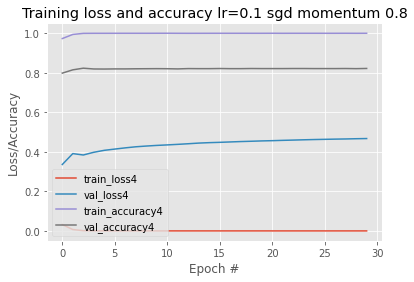

In [ ]:

import matplotlib.pyplot as plt
N = np.arange(0, 30)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H4.history['loss'], label='train_loss4')
plt.plot(N, H4.history['val_loss'], label='val_loss4')
plt.plot(N, H4.history['accuracy'], label='train_accuracy4')
plt.plot(N, H4.history['val_accuracy'], label='val_accuracy4')


plt.title('Training loss and accuracy lr=0.1 sgd momentum 0.8')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [ ]:
#TRYING DIFFERENT PARAMETERS (lr=0.001 rmsprop batch_size=128)

from keras.optimizers import RMSprop
import datetime
now = datetime.datetime.now
t = now()
rmsprop = RMSprop(lr=0.01, decay=1e-7, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=rmsprop,
              metrics=['accuracy'])
H5 = model.fit(X_train, y_train, batch_size=128,
              epochs=30, 
              validation_data=(X_test, y_test))
print('Training time: %s' % (now() - t))
best_scoreH5 = max(H5.history['accuracy'])
print(best_scoreH5)

Epoch 1/30
110/110 [==============================] - 8s 64ms/step - loss: 1.7947 - accuracy: 0.1766 - val_loss: 1.7976 - val_accuracy: 0.1750
Epoch 2/30
110/110 [==============================] - 7s 62ms/step - loss: 1.7942 - accuracy: 0.1769 - val_loss: 1.7990 - val_accuracy: 0.1750
Epoch 3/30
110/110 [==============================] - 7s 62ms/step - loss: 1.7951 - accuracy: 0.1707 - val_loss: 1.7966 - val_accuracy: 0.1670
Epoch 4/30
110/110 [==============================] - 7s 63ms/step - loss: 1.7947 - accuracy: 0.1670 - val_loss: 1.7917 - val_accuracy: 0.1843
Epoch 5/30
110/110 [==============================] - 7s 62ms/step - loss: 1.7973 - accuracy: 0.1630 - val_loss: 1.7932 - val_accuracy: 0.1750
Epoch 6/30
110/110 [==============================] - 7s 62ms/step - loss: 1.7938 - accuracy: 0.1661 - val_loss: 1.7904 - val_accuracy: 0.1700
Epoch 7/30
110/110 [==============================] - 7s 62ms/step - loss: 1.7939 - accuracy: 0.1684 - val_loss: 1.7904 - val_accuracy: 0.1843

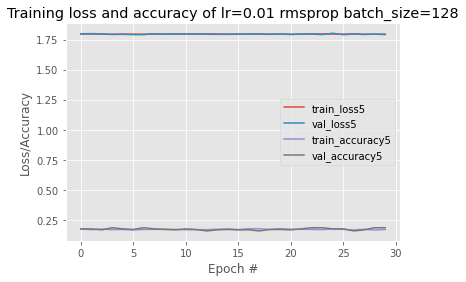

In [ ]:

import matplotlib.pyplot as plt
N = np.arange(0, 30)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H5.history['loss'], label='train_loss5')
plt.plot(N, H5.history['val_loss'], label='val_loss5')
plt.plot(N, H5.history['accuracy'], label='train_accuracy5')
plt.plot(N, H5.history['val_accuracy'], label='val_accuracy5')


plt.title('Training loss and accuracy of lr=0.01 rmsprop batch_size=128')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

**Best results**
After training with different hyperparameters, I got best results from SGD optimizer with lr=0.1, momentum=0.8, decay rate= lr/epochs

In [16]:
#TRYING DIFFERENT PARAMETERS (lr=0.01 SGD batch_size=64 decay=1e-5)
import datetime
now = datetime.datetime.now
t = now()
from keras.optimizers import SGD
sgd = SGD(lr=0.01, decay=1e-5, momentum=.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])
H2 = model.fit(X_train, y_train, batch_size=64,
              epochs=30, 
              validation_data=(X_test, y_test))
print('Training time: %s' % (now() - t))
best_score = max(H2.history['accuracy'])
print(best_score)

Epoch 1/30
220/220 [==============================] - 17s 42ms/step - loss: 1.7916 - accuracy: 0.1735 - val_loss: 1.7906 - val_accuracy: 0.1750
Epoch 2/30
220/220 [==============================] - 9s 39ms/step - loss: 1.7905 - accuracy: 0.1829 - val_loss: 1.7781 - val_accuracy: 0.2753
Epoch 3/30
220/220 [==============================] - 9s 39ms/step - loss: 1.6836 - accuracy: 0.3077 - val_loss: 1.4618 - val_accuracy: 0.4097
Epoch 4/30
220/220 [==============================] - 9s 39ms/step - loss: 1.3402 - accuracy: 0.4515 - val_loss: 1.1392 - val_accuracy: 0.5170
Epoch 5/30
220/220 [==============================] - 9s 39ms/step - loss: 1.1258 - accuracy: 0.5289 - val_loss: 0.9776 - val_accuracy: 0.6060
Epoch 6/30
220/220 [==============================] - 9s 40ms/step - loss: 0.9979 - accuracy: 0.6048 - val_loss: 0.9831 - val_accuracy: 0.6203
Epoch 7/30
220/220 [==============================] - 9s 40ms/step - loss: 0.9265 - accuracy: 0.6406 - val_loss: 0.8937 - val_accuracy: 0.659

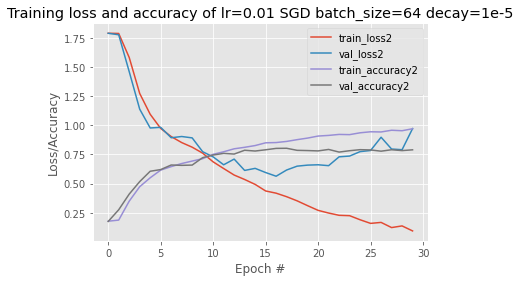

<Figure size 432x288 with 0 Axes>

In [17]:
N = np.arange(0, 30)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H2.history['loss'], label='train_loss2')
plt.plot(N, H2.history['val_loss'], label='val_loss2')
plt.plot(N, H2.history['accuracy'], label='train_accuracy2')
plt.plot(N, H2.history['val_accuracy'], label='val_accuracy2')


plt.title('Training loss and accuracy of lr=0.01 SGD batch_size=64 decay=1e-5')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

plt.savefig("self_made_image_aug_best_plot.png")

In [24]:
# save the model's trained weights
model.save_weights('image_augmodel_wts.h5')

In [23]:
score = model.evaluate(X_pred, y_pred, batch_size=64)
print('Test Loss = ', score[0])
print('Test Accuracy = ', score[1])

115/115 [==============================] - 1s 12ms/step - loss: 0.9695 - accuracy: 0.7924
Test Loss =  0.9694951176643372
Test Accuracy =  0.7923572063446045


In [26]:
'''CONFUSION MATRIX'''
import pandas as pd
# Making prediction
y_pred = model.predict_classes(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, y_pred)

predY_classes = y_test.argmax(1)
confusion_matrix = pd.crosstab(y_true, predY_classes,margins=True)
print("Confusion matrix:\n%s" % confusion_matrix)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion matrix:
col_0    0    1    2    3    4    5   All
row_0                                    
0      437    0    0    0    0    0   437
1        0  474    0    0    0    0   474
2        0    0  553    0    0    0   553
3        0    0    0  525    0    0   525
4        0    0    0    0  510    0   510
5        0    0    0    0    0  501   501
All    437  474  553  525  510  501  3000


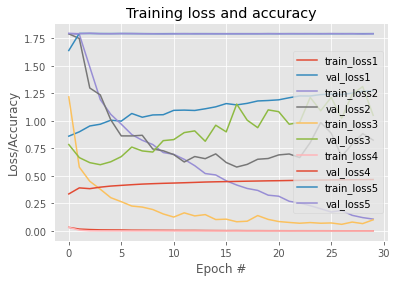

<Figure size 432x288 with 0 Axes>

In [ ]:
'''LEARNING CURVE'''

import matplotlib.pyplot as plt
N = np.arange(0, 30)
plt.style.use('ggplot')
plt.figure()

plt.plot(N, H1.history['loss'], label='train_loss1')
plt.plot(N, H1.history['val_loss'], label='val_loss1')
# plt.plot(N, H1.history['accuracy'], label='train_accuracy')
# plt.plot(N, H1.history['val_accuracy'], label='val_accuracy')

plt.plot(N, H2.history['loss'], label='train_loss2')
plt.plot(N, H2.history['val_loss'], label='val_loss2')
# plt.plot(N, H2.history['accuracy'], label='train_accuracy')
# plt.plot(N, H2.history['val_accuracy'], label='val_accuracy')

plt.plot(N, H3.history['loss'], label='train_loss3')
plt.plot(N, H3.history['val_loss'], label='val_loss3')
# plt.plot(N, H3.history['accuracy'], label='train_accuracy')
# plt.plot(N, H3.history['val_accuracy'], label='val_accuracy')


plt.plot(N, H4.history['loss'], label='train_loss4')
plt.plot(N, H4.history['val_loss'], label='val_loss4')
# plt.plot(N, H4.history['accuracy'], label='train_accuracy')
# plt.plot(N, H4.history['val_accuracy'], label='val_accuracy')


plt.plot(N, H5.history['loss'], label='train_loss5')
plt.plot(N, H5.history['val_loss'], label='val_loss5')
# plt.plot(N, H5.history['accuracy'], label='train_accuracy')
# plt.plot(N, H5.history['val_accuracy'], label='val_accuracy')

plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()
plt.savefig("self_made_aug_all.png")